In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn
sklearn.set_config(transform_output="pandas")
import category_encoders as ce
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate
import matplotlib.pyplot as plt # visualization library to support seaborn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.dummy import DummyClassifier
%matplotlib inline

In [15]:
df = pd.read_csv('./data/final_script.csv')
df = df.loc[:,~df.columns.str.startswith('Unnamed')]
df.head(5)

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,...,sim1_legal_question_score,sim1_conclusion_score,sim2_facts_score,sim2_issue_area_score,sim1_facts_href,sim2_facts_href,sim1_issue_area_href,sim2_issue_area_href,sim1_legal_question_href,sim1_conclusion_href
0,53057,City of Oklahoma City v. Tuttle,https://api.oyez.org/cases/1984/83-1919,83-1919,1984,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","<p>On October 10, 1980, an Oklahoma City polic...",952,7,...,0.882680,0.910945,0.880510,1.0,https://api.oyez.org/cases/1997/96-957,https://api.oyez.org/cases/2013/13-551,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/2016/16-369,https://api.oyez.org/cases/1997/96-827
1,55708,City of Ontario v. Quon,https://api.oyez.org/cases/2009/08-1332,08-1332,2009,"City of Ontario, California et al.","Jeff Quon, et al.","<p>Employees of the City of Ontario, Californi...",1494,9,...,0.889324,0.910785,0.877608,1.0,https://api.oyez.org/cases/2004/03-710,https://api.oyez.org/cases/1988/87-6571,https://api.oyez.org/cases/2011/10-637,https://api.oyez.org/cases/1999/98-1036,https://api.oyez.org/cases/1988/87-764,https://api.oyez.org/cases/2011/10-1259
2,51555,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1976/75-1150,75-1150,1976,City of Philadelphia et al.,New Jersey et al.,<p>A New Jersey statute prohibited the importa...,430,5,...,0.913905,0.892045,0.865124,1.0,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1940-1955/330us1,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1978/77-154
3,51844,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1977/77-404,77-404,1977,City of Philadelphia,New Jersey,<p>A New Jersey law prohibited the importation...,162,7,...,0.917768,0.910676,0.863157,1.0,https://api.oyez.org/cases/1976/75-1150,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/1993/93-70
4,55235,City of Rancho Palos Verdes v. Abrams,https://api.oyez.org/cases/2004/03-1601,03-1601,2004,"City of Rancho Palos Verdes, California, et al.",Mark J. Abrams,"<p>Rancho Palos Verdes, a city in California, ...",1094,9,...,0.843087,0.828414,0.884123,1.0,https://api.oyez.org/cases/2003/02-1238,https://api.oyez.org/cases/2014/13-975,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/1999/98-791,https://api.oyez.org/cases/1940-1955/341us494


In [16]:
df['issue_area'].unique()
df.groupby('issue_area').size()

drop_issue_area = ['interstate relations', 'majority opinion', 'private action']
# df['issue_area'].value_counts().plot(kind='bar')
df = df[~df['issue_area'].isin(drop_issue_area)]
df.groupby('issue_area').size()

issue_area
attorneys              32
civil rights          469
criminal procedure    709
due process           102
economic activity     439
federal taxation       45
federalism             96
first amendment       290
judicial power        274
miscellaneous          19
privacy                59
unions                 46
dtype: int64

In [17]:
df['fpw'] = df['first_party_winner'].map({'True': 1,'False' :0 })
min_df = df[['href', 'fpw', 'issue_area']]
sim1_facts_df = pd.merge(df, min_df, how="left", suffixes=(None, '_sim1_facts'), left_on='sim1_facts_href', right_on='href')
sim2_facts_df = pd.merge(sim1_facts_df, min_df, how="left", suffixes=(None, '_sim2_facts'), left_on='sim2_facts_href', right_on='href')

sim1_issue_area_df = pd.merge(sim2_facts_df, min_df, how="left", suffixes=(None, '_sim1_issue_area'), left_on='sim1_issue_area_href', right_on='href')
sim2_issue_area_df = pd.merge(sim1_issue_area_df, min_df, how="left", suffixes=(None, '_sim2_issue_area'), left_on='sim2_issue_area_href', right_on='href')

sim1_legal_question_df = pd.merge(sim2_issue_area_df, min_df, how="left", suffixes=(None, '_sim1_legal_question'), left_on='sim1_legal_question_href', right_on='href')

sim1_conclusion_df = pd.merge(sim1_legal_question_df, min_df, how="left", suffixes=(None, '_sim1_conclusion'), left_on='sim1_conclusion_href', right_on='href')

merged_df = sim1_conclusion_df
merged_df['fpw'] = merged_df[merged_df['fpw'].notna()]['fpw'].astype(int)
merged_df = merged_df[merged_df['issue_area'].notna()]

In [18]:
print(list(merged_df.filter(regex='issue_area')))

['issue_area', 'sim1_issue_area_score', 'sim2_issue_area_score', 'sim1_issue_area_href', 'sim2_issue_area_href', 'issue_area_sim1_facts', 'issue_area_sim2_facts', 'href_sim1_issue_area', 'fpw_sim1_issue_area', 'issue_area_sim1_issue_area', 'href_sim2_issue_area', 'fpw_sim2_issue_area', 'issue_area_sim2_issue_area', 'issue_area_sim1_legal_question', 'issue_area_sim1_conclusion']


In [20]:
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='Unnamed')))]
# merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='_issue_area')))]
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='^issue_area_')))]
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='href')))]
merged_df = merged_df[merged_df['term'].str.isnumeric()]
merged_df = merged_df.drop('ID', axis=1)
merged_df = merged_df.drop('name', axis=1)
merged_df = merged_df.drop('docket', axis=1)
merged_df = merged_df.drop('facts', axis=1)
merged_df = merged_df.drop('facts_len', axis=1)
merged_df = merged_df.drop('majority_vote', axis=1)
merged_df = merged_df.drop('minority_vote', axis=1)
merged_df = merged_df.drop('disposition', axis=1)
merged_df = merged_df.drop('decision_type', axis=1)
merged_df = merged_df.drop('first_party_winner', axis=1)
merged_df = merged_df.drop('legal_question', axis=1)
merged_df = merged_df.drop('facts_clean', axis=1)
merged_df = merged_df.drop('conclusion', axis=1)
# merged_df = merged_df.drop('issue_area_sim2_issue_area', axis=1)
# merged_df = merged_df.drop('issue_area_sim1_issue_area', axis=1)
merged_df['term'] = merged_df['term'].astype('float')

merged_df.columns
print(list(merged_df.filter(regex='issue_area')))


['issue_area', 'sim1_issue_area_score', 'sim2_issue_area_score', 'fpw_sim1_issue_area', 'fpw_sim2_issue_area']


In [21]:
cat_vars = ['first_party',
            'second_party',
            'issue_area',
            'first_party_entity',
            'second_party_entity',
            'judges',
            'lower_court']
for col in cat_vars:
    merged_df[col] = merged_df[col].astype('category')

In [ ]:
merged_df.to_csv('for_training.csv')

<Axes: >

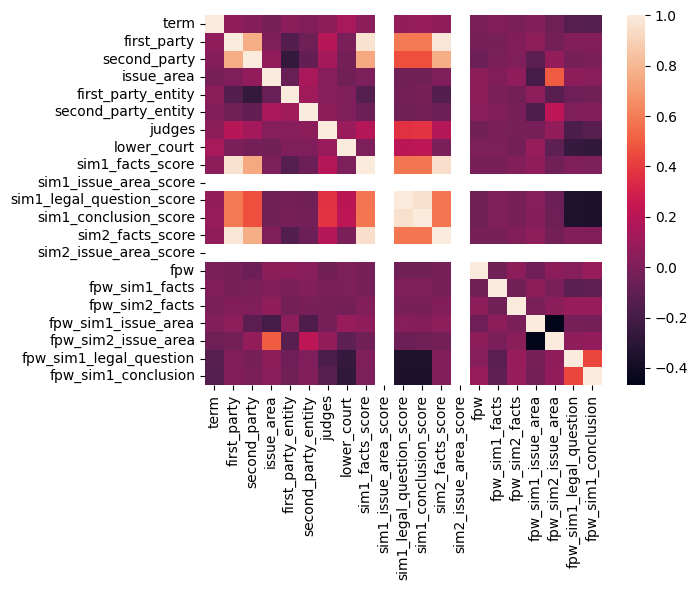

In [22]:
corr = merged_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr)

In [23]:
# corr_matrix = merged_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if (column!='issue_area' and any(upper[column] > 0.95))]

# Drop features 
merged_df.drop(to_drop, axis=1, inplace=True)
list(merged_df.columns)

['term',
 'first_party',
 'second_party',
 'issue_area',
 'first_party_entity',
 'second_party_entity',
 'judges',
 'lower_court',
 'sim1_issue_area_score',
 'sim1_legal_question_score',
 'sim2_issue_area_score',
 'fpw',
 'fpw_sim1_facts',
 'fpw_sim2_facts',
 'fpw_sim1_issue_area',
 'fpw_sim2_issue_area',
 'fpw_sim1_legal_question',
 'fpw_sim1_conclusion']

In [24]:
merged_df.columns

Index(['term', 'first_party', 'second_party', 'issue_area',
       'first_party_entity', 'second_party_entity', 'judges', 'lower_court',
       'sim1_issue_area_score', 'sim1_legal_question_score',
       'sim2_issue_area_score', 'fpw', 'fpw_sim1_facts', 'fpw_sim2_facts',
       'fpw_sim1_issue_area', 'fpw_sim2_issue_area', 'fpw_sim1_legal_question',
       'fpw_sim1_conclusion'],
      dtype='object')

In [25]:
y = merged_df['issue_area'].copy()
X = merged_df.drop('issue_area', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

In [27]:
#Function for evaluation metrics
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred, average='macro'),
                    'precision': precision_score(y_true, y_pred, average='macro'),
                    'f1_score': f1_score(y_true, y_pred, average='macro')}
    return results_dict

print(print_binary_evaluation(X_train, X_test,y_train_enc, y_test_enc, 'stratified'))
print(print_binary_evaluation(X_train, X_test,y_train_enc, y_test_enc, 'uniform'))
print(print_binary_evaluation(X_train, X_test,y_train_enc, y_test_enc, 'most_frequent'))

{'accuracy': 0.1569767441860465, 'recall': 0.0780185124036844, 'precision': 0.08205096837323159, 'f1_score': 0.07936473905370937}
{'accuracy': 0.10271317829457365, 'recall': 0.0892216094789453, 'precision': 0.10415979092889394, 'f1_score': 0.07785036072056302}
{'accuracy': 0.2751937984496124, 'recall': 0.08333333333333333, 'precision': 0.0229328165374677, 'f1_score': 0.03596757852077001}


c:\Users\Jordan\anaconda3\envs\fv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


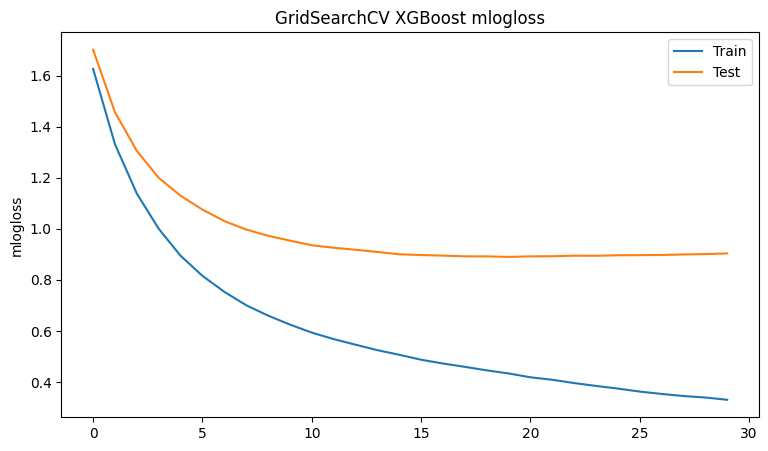

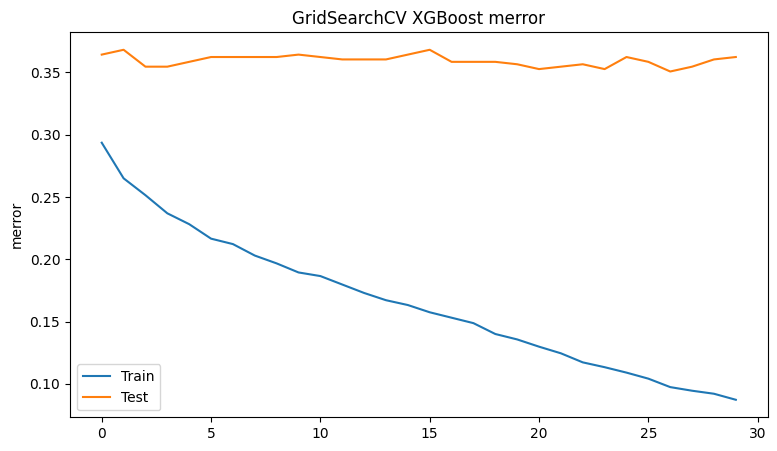


------------------ Confusion Matrix -----------------

[[  0   0   0   0   5   0   1   0   0   0   0   0]
 [  0  77   0   1   0   0   0  16   0   0   0   0]
 [  0   0 139   0   0   0   0   1   0   0   2   0]
 [  0  14   0   2   0   0   0   4   0   0   0   0]
 [  0   0   0   0  65   3   2   0  17   0   0   1]
 [  0   0   0   0   4   2   1   0   2   0   0   0]
 [  0   0   0   0  13   0   1   0   5   0   0   0]
 [  0  34   0   0   0   0   0  24   0   0   0   0]
 [  0   0   0   0  38   0   0   0  15   0   0   2]
 [  0   0   0   0   0   0   0   0   0   4   0   0]
 [  0   1   8   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   7   0   1   0   1   0   0   0]]

-------------------- Key Metrics --------------------

Accuracy: 0.64
Balanced Accuracy: 0.40

Micro Precision: 0.64
Micro Recall: 0.64
Micro F1-score: 0.64

Macro Precision: 0.48
Macro Recall: 0.40
Macro F1-score: 0.41

Weighted Precision: 0.62
Weighted Recall: 0.64
Weighted F1-score: 0.61

--------------- Classification Report

c:\Users\Rachel\anaconda3\envs\fv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rachel\anaconda3\envs\fv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rachel\anaconda3\envs\fv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rachel\anaconda3\envs\fv\lib\site-packages\sk

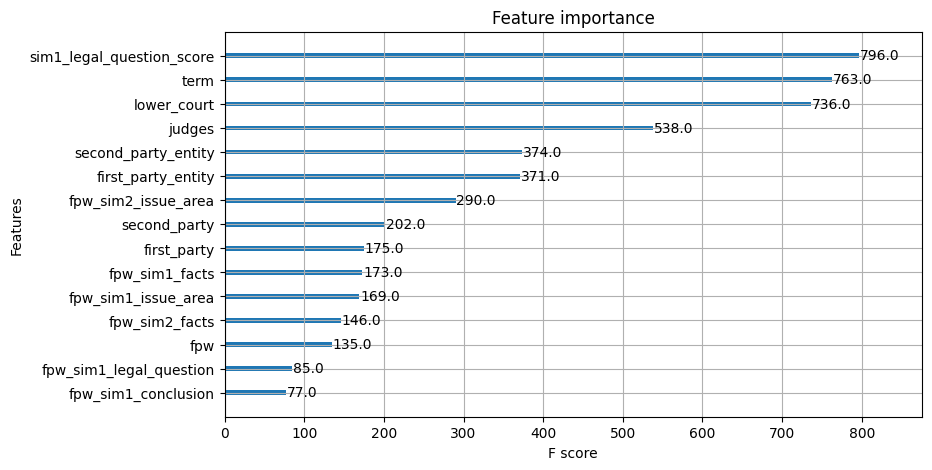

In [ ]:


## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            enable_categorical=True)
xgb_clf.fit(X_train, 
            y_train_enc,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train_enc), (X_test, y_test_enc)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test_enc, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test_enc, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test_enc, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_enc, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_enc, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_enc, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_enc, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_enc, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_enc, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_enc, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_enc, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_enc, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test_enc, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

In [ ]:

file_name = "xgb_fpw.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

In [ ]:


# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# # test
# ind = 1
# test = X_val[ind]
# xgb_model_loaded.predict(test)[0] == xgb_model.predict(test)[0]

In [ ]:
df = pd.read_csv('./data/prediction/prediction_final_script.csv')